In [49]:
# Data manipulation library
import pandas as pd
import os
import numpy as np

from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [50]:
# Load Dataset
cat_folder = 'PetImages/Cat'  
dog_folder = 'PetImages/Dog'  

In [51]:
# Mengumpulkan gambar dengan format jpg dan png
cat_images = [os.path.join(cat_folder, f) for f in os.listdir(cat_folder) if f.endswith(('jpg', 'png'))]
dog_images = [os.path.join(dog_folder, f) for f in os.listdir(dog_folder) if f.endswith(('jpg', 'png'))]

In [52]:
# membuat label
cat_labels = ['cat'] * len(cat_images)
dog_labels = ['dog'] * len(dog_images)

In [53]:
# Menggabungkan label dan path gambar ke dalam dataframe
image_paths = cat_images + dog_images
labels = cat_labels + dog_labels

In [54]:
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

In [55]:
print(df)

                   image_path label
0         PetImages/Cat\0.jpg   cat
1         PetImages/Cat\1.jpg   cat
2        PetImages/Cat\10.jpg   cat
3       PetImages/Cat\100.jpg   cat
4      PetImages/Cat\1000.jpg   cat
...                       ...   ...
24993  PetImages/Dog\9995.jpg   dog
24994  PetImages/Dog\9996.jpg   dog
24995  PetImages/Dog\9997.jpg   dog
24996  PetImages/Dog\9998.jpg   dog
24997  PetImages/Dog\9999.jpg   dog

[24998 rows x 2 columns]


In [56]:
print(f"Jumlah gambar CAT: {len(cat_images)}")
print(f"Jumlah gambar DOG: {len(dog_images)}")

Jumlah gambar CAT: 12499
Jumlah gambar DOG: 12499


# Data Split

In [58]:
import os
import shutil
import random

# Path ke direktori utama
source_dir = 'PetImages'

# Path ke direktori train dan validation
train_dir = 'PetImages/train'
validation_dir = 'PetImages/validation'

# Membuat folder 'train' dan 'validation' jika belum ada
os.makedirs(os.path.join(train_dir, 'CAT'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'DOG'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'CAT'), exist_ok=True)
os.makedirs(os.path.join(validation_dir, 'DOG'), exist_ok=True)

# Folder data untuk CAT dan DOG
cat_dir = os.path.join(source_dir, 'CAT')
dog_dir = os.path.join(source_dir, 'DOG')

# Fungsi untuk membagi gambar
def split_data(source_folder, train_folder, validation_folder, validation_ratio=0.2):
    
    files = os.listdir(source_folder)
    
    random.shuffle(files)
    
    num_validation = int(len(files) * validation_ratio)
    
    # Membagi file
    validation_files = files[:num_validation]
    train_files = files[num_validation:]
    
    # Memindahkan gambar ke folder yang sesuai
    for file in train_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(train_folder, file))
    
    for file in validation_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(validation_folder, file))

# Membagi data untuk folder CAT
split_data(cat_dir, os.path.join(train_dir, 'CAT'), os.path.join(validation_dir, 'CAT'))

# Membagi data untuk folder DOG
split_data(dog_dir, os.path.join(train_dir, 'DOG'), os.path.join(validation_dir, 'DOG'))

print("Data telah dibagi menjadi train dan validation.")


Data telah dibagi menjadi train dan validation.


# Preprocessing

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation untuk pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar
)

validation_datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi saja untuk data validasi

train_generator = train_datagen.flow_from_directory(
    'PetImages/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    'PetImages/validation',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 24992 images belonging to 2 classes.
Found 13148 images belonging to 2 classes.


## Ploting 

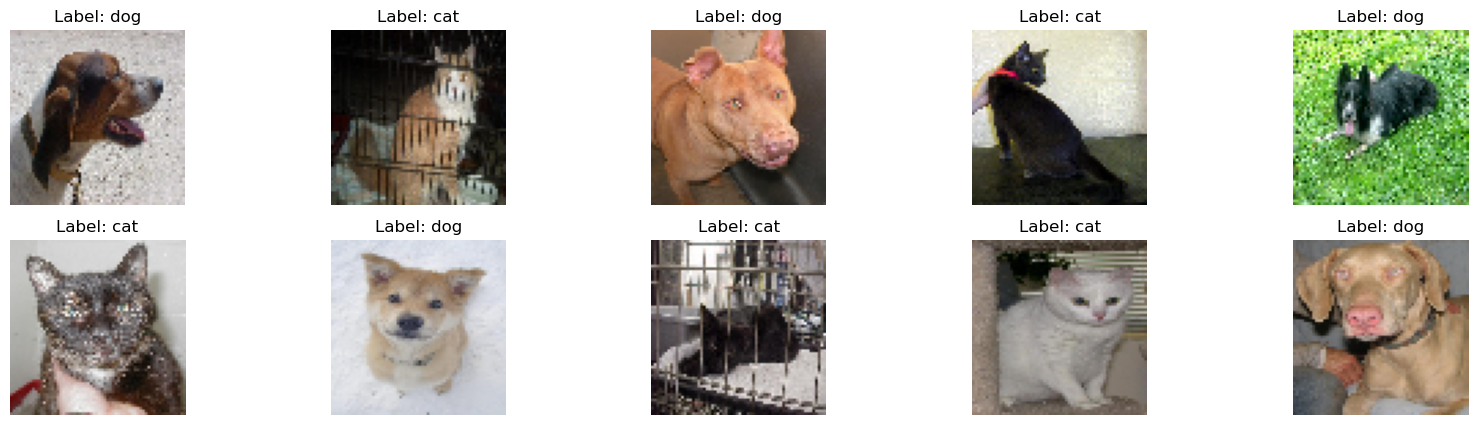

In [62]:

batch = next(train_generator)
images = batch[0] 
labels = batch[1]


fig, axes = plt.subplots(2, 5, figsize=(20, 5))

for i, ax in enumerate(axes.flat):
 
    ax.imshow(images[i]) 
    label = 'dog' if labels[i] == 1 else 'cat'
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.show()


# Modelling

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Membangun model CNN
model = Sequential()

model.add(Input(shape=(64, 64, 3)))  # Dimensi input diatur menggunakan Input layer


model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [65]:
history = model.fit(
    train_generator,
    steps_per_epoch=20,  # Lebih sedikit dari jumlah batch total
    epochs=100,
    validation_data=validation_generator,
    validation_steps=10,
    verbose=1
)

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 503ms/step - accuracy: 0.4891 - loss: 0.7451 - val_accuracy: 0.5437 - val_loss: 0.6879
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - accuracy: 0.5534 - loss: 0.6880 - val_accuracy: 0.5906 - val_loss: 0.6825
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step - accuracy: 0.4792 - loss: 0.7005 - val_accuracy: 0.5375 - val_loss: 0.6902
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - accuracy: 0.5469 - loss: 0.6902 - val_accuracy: 0.5500 - val_loss: 0.6719
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.5691 - loss: 0.6834 - val_accuracy: 0.6281 - val_loss: 0.6560
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5690 - loss: 0.6682

C:\Users\ASUS\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.5696 - loss: 0.6683 - val_accuracy: 0.6469 - val_loss: 0.6465
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.6085 - loss: 0.6632 - val_accuracy: 0.6062 - val_loss: 0.6657
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - accuracy: 0.5693 - loss: 0.6817 - val_accuracy: 0.6625 - val_loss: 0.6489
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.6040 - loss: 0.6544 - val_accuracy: 0.5781 - val_loss: 0.6978
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.6259 - loss: 0.6536 - val_accuracy: 0.6500 - val_loss: 0.6458
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.6551 - loss: 0.6452 - val_accuracy: 0.6906 - val_loss: 0.6222
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - accuracy: 0.7244 - loss: 0.5898 - val_accuracy: 0.6812 - val_loss: 0.5960
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.6621 - loss: 0.6288 - val_accuracy: 0.

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8125 - loss: 0.5421 - val_accuracy: 0.7500 - val_loss: 0.5388
Epoch 41/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.7800 - loss: 0.5300 - val_accuracy: 0.7781 - val_loss: 0.4581
Epoch 42/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.7347 - loss: 0.5309 - val_accuracy: 0.7594 - val_loss: 0.4886
Epoch 43/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.7603 - loss: 0.4961 - val_accuracy: 0.8000 - val_loss: 0.4555
Epoch 44/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.7470 - loss: 0.5199 - val_accuracy: 0.7688 - val_loss: 0.4848
Epoch 45/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.7835 - loss: 0.4794 - val_accuracy: 0.7375 - val_loss: 0.5149
Epoch 46/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.7382 - loss: 0.4989 - val_accuracy: 0.7531 - val_loss: 0.5412
Epoch 47/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.7376 - loss: 0.5077 - val_accuracy: 

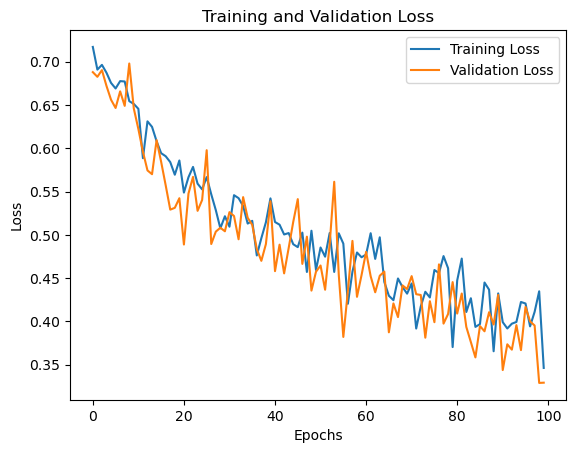

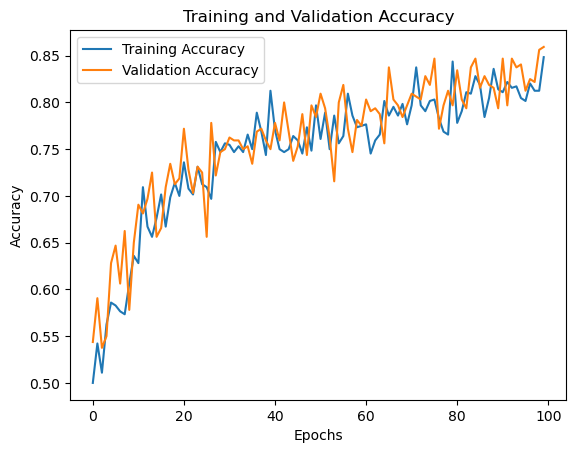

In [66]:
import matplotlib.pyplot as plt

# Plot the training and validation loss or accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# You can also plot accuracy if you prefer
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Evaluasi

In [68]:
# Evaluasi model pada data validasi
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


102/410 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step - accuracy: 0.8423 - loss: 0.3584

C:\Users\ASUS\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


410/410 ━━━━━━━━━━━━━━━━━━━━ 35s 86ms/step - accuracy: 0.8365 - loss: 0.3666
Validation Loss: 0.3655029535293579
Validation Accuracy: 0.8358231782913208


## Membuat folder test

In [70]:
import os
import shutil
import random

source_validation_dir = 'PetImages/validation'
test_dir = 'PetImages/test'

os.makedirs(test_dir, exist_ok=True)


os.makedirs(os.path.join(test_dir, 'CAT'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'DOG'), exist_ok=True)


def split_data(source_folder, destination_folder, split_ratio=0.2):
    
    for class_name in os.listdir(source_folder):
        class_folder = os.path.join(source_folder, class_name)
        if os.path.isdir(class_folder):
            files = os.listdir(class_folder)
            random.shuffle(files)

            
            num_test_files = int(len(files) * split_ratio)
            test_files = files[:num_test_files]

            
            for file in test_files:
                shutil.move(os.path.join(class_folder, file), os.path.join(destination_folder, class_name, file))


split_data(source_validation_dir, test_dir, split_ratio=0.2)

print("Data successfully split into test and validation.")


Data successfully split into test and validation.


In [71]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'PetImages/test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
)

# Evaluasi pada test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


Found 7284 images belonging to 2 classes.


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


227/227 ━━━━━━━━━━━━━━━━━━━━ 47s 208ms/step - accuracy: 0.8505 - loss: 0.3490
Test Loss: 0.35395342111587524
Test Accuracy: 0.8451266288757324


# Test Prediksi (Menggunakan gambar dari internet)

In [73]:
# Menggunakan model untuk prediksi gambar baru
from tensorflow.keras.preprocessing import image
import numpy as np

# Memuat gambar baru
img = image.load_img("D:\\alley-our-bnr.jpg", target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Mengubah dimensi gambar menjadi batch

# Melakukan prediksi
prediction = model.predict(img_array)
print(f"Prediksi: {'Cat' if prediction[0] < 0.5 else 'Dog'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Prediksi: Cat


In [74]:
img = image.load_img(r"C:\Users\ASUS\OneDrive\Pictures\Golden-Retriever.png", 
                     target_size=(64, 64))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
print(f"Prediksi: {'Cat' if prediction[0] < 0.5 else 'Dog'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediksi: Dog


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


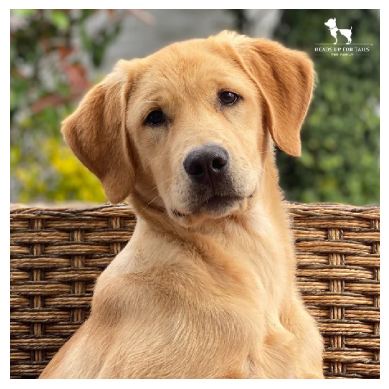

Your picture is: a Dog


In [110]:
img_path = r"C:\Users\ASUS\OneDrive\Pictures\Golden-Retriever.png"

img = image.load_img(img_path, target_size=(64, 64))

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

img_for_display = image.load_img(img_path, target_size=(512, 512))
plt.imshow(img_for_display)
plt.axis('off') 
plt.show()

if prediction[0] < 0.5:
    print(f"Your picture is: a Cat")
else:
    print(f"Your picture is: a Dog")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


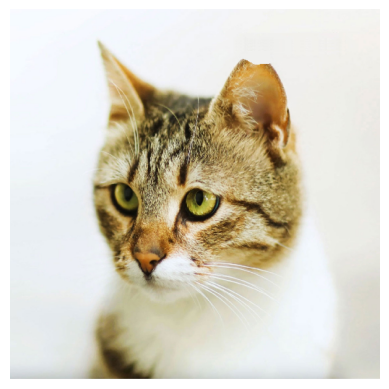

Your picture is: a Cat


In [104]:
img_path = "D:\\alley-our-bnr.jpg"

img = image.load_img(img_path, target_size=(64, 64))

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

img_for_display = image.load_img(img_path, target_size=(512, 512))
plt.imshow(img_for_display)
plt.axis('off') 
plt.show()

if prediction[0] < 0.5:
    print(f"Your picture is: a Cat")
else:
    print(f"Your picture is: a Dog")

